In [ ]:
# ! conda install -c conda-forge mlxtend

# ! conda list --export > exported-packages.txt
# ! conda create -n py3clone --file exported-packages.txt # edit out python version b4 running if you want
# # a different version
# #OR
# ! conda create -n clonedenv --clone oldenv #√√√√√√√√√
# ! conda install -n clonedenv python=3.10
# ! conda update -n clonedenv --all

In [1]:
import pandas as pd
# pd.set_option("display.float_format", "{:.3f}".format)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay)
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import shap
import seaborn as sns
from IPython.display import display, Markdown, Latex
import random
random.seed(42)
import os
 
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.set_seed(seed)
    random.seed

In [2]:
dff = pd.read_csv('/Users/kayadetunji/Documents/AWI_GEN_PROJECT/cvd_data_awigenv1.csv').drop(columns = 
       ['Unnamed: 0', 'study_id', 'chf_meds_qc','angina_meds_qc', 'pain_action_stop_or_slow_qc', 'pain_action_rest_qc',
       'pain_action_medicine_qc', 'pain_action_carry_on_qc',
       'relief_standstill_qc', 'relief_standstill_qc.1', 'pain_location_1_qc',
       'pain_location_2_qc', 'pain_location_3_qc', 'pain_location_4_qc',
       'pain_location_5_qc', 'pain_location_6_qc', 'pain_location_7_qc',
       'pain_location_8_qc', 'pain_location_9_qc', 'pain_location_10_qc',
       'pain_location_11_qc', 'pain_location_12_qc', 'pain_location_13_qc',
       'pain_location_14_qc', 'pain_location_15_qc', 'pain_location_16_qc',
       'pain_location_17_qc', 'pain_location_18_qc','angina_treat_now_qc', 'angina_traditional_qc', 'pain_qc', 'pain2_qc'])

In [3]:
dff.columns

Index(['site', 'age', 'sex', 'number_of_children_c', 'partnership_status_c_qc',
       'highest_level_of_education_qc', 'occupation_qc',
       'ses_site_quintile_c_qc', 'smoking_status_c_qc',
       'alcohol_use_status_c_qc', 'days_fruit_qc', 'days_veg_qc',
       'days_bread_qc', 'sugardrinks_qc', 'avg_sleep_per_night_c', 'mvpa_c',
       'asthma_qc', 'obesity_mom_qc', 'hiv_final_status_c', 'pesticide_qc',
       'waist_circumference_qc', 'hip_circumference_qc', 'waist_hip_r_c_qc',
       'bp_sys_average_qc', 'bp_dia_average_qc', 'pulse_average_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'mean_cimt_right_qc',
       'mean_cimt_left_qc', 's_creatinine_qc', 'ldl_qc', 'triglycerides_qc',
       'acr_qc', 'egfr_c_qc', 'cholesterol_1_qc', 'stroke_qc',
       'stroke_diagnosed_qc', 'transient_ischemic_attack_qc', 'weakness_qc',
       'numbness_qc', 'blindness_qc', 'half_vision_loss_qc',
       'understanding_loss_qc', 'expression_loss_qc', 'angina_qc',
       'angina_treatment_y

**Adopted predictors**

age, sex, number_of_children_c, partnership_status_c_qc, highest_level_of_education_qc, occupation_qc, ses_site_quintile_c_qc, smoking_status_c_qc, alcohol_use_status_c_qc, days_fruit_qc, days_veg_qc, days_bread_qc, sugardrinks_qc, avg_sleep_per_night_c, mvpa_c, obesity_mom_qc, hiv_final_status_c, pesticide_qc,waist_hip_r_c_qc, visceral_fat_qc, subcutaneous_fat_qc, mean_cimt_right_qc,mean_cimt_left_qc, ldl_qc, triglycerides_qc, bmi_c_qc, and cholesterol_1_qc

In [4]:
predictor_cols = [#'site', 
       'age', 'sex', 'number_of_children_c', 
        'partnership_status_c_qc', 'highest_level_of_education_qc', 'occupation_qc',
       'ses_site_quintile_c_qc', 'smoking_status_c_qc', 'alcohol_use_status_c_qc', 
#        'days_fruit_qc', 'days_veg_qc', 'days_bread_qc', 'sugardrinks_qc', 
       'avg_sleep_per_night_c', 'mvpa_c',
#        'asthma_qc', 
       'obesity_mom_qc','hiv_final_status_c', 'pesticide_qc',
       # 'waist_circumference_qc', 'hip_circumference_qc', 
       'waist_hip_r_c_qc', 
       # 'pulse_average_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'mean_cimt_right_qc',
       'mean_cimt_left_qc', 'ldl_qc', 'triglycerides_qc',
       'bmi_c_qc', 'cholesterol_1_qc']
outcome_cols = ['CVD']

#### **Slice data to ages between 40 and 65**

In [5]:
dff = dff[(dff['age'] <= 65) & (dff['age'] >= 40)].copy()

In [6]:
# Simple Function to calcuate CVD
def calculate_CVD(a,b,c,d,e):
    col=0
    if (int(a)==1 or int(b)==1 or int(c)==1 or int(d)==1 or int(e)==1):
        col=1
    elif (int(a)==0 and int(b)==0 and int(c)==0 and int(d)==0 and int(e)==0):
        col = 0
    elif (int(a)==pd.isna and int(b)==pd.isna and int(c)==pd.isna and int(d)==pd.isna and int(e)==pd.isna):
        col = 0
    return col

In [7]:
# Simple Function to calcuate CVD multimorbidity
def calculate_CVD_MM(a,b,c,d):
    col=0
    if (int(a)==1 or int(b)==1 or int(c)==1 or int(d)==1):
        col=1
    elif (int(a)==1 and int(b)==1 and int(c)==0 and int(d)==0):
        col = 1
    elif (int(a)==0 or int(b)==0 and int(c)==0 and int(d)==0):
        col = 0
    elif (int(a)==0 and int(b)==0 and int(c)==1 or int(d)==1):
        col = 0
    return col

In [8]:
# Simple Function to calcuate CVD multimorbidity
def calculate_CVD_MM(a,b,c,d):
    col=0
    if (int(a)==1 or int(b)==1 or int(c)==1 or int(d)==1):
        col=1
    elif (int(a)==1 and int(b)==1 and int(c)==0 and int(d)==0):
        col = 1
    elif (int(a)==0 or int(b)==0 and int(c)==0 and int(d)==0):
        col = 0
    elif (int(a)==0 and int(b)==0 and int(c)==1 or int(d)==1):
        col = 0
    elif (int(a)==0 and int(b)==0 and int(c)==0 or int(d)==1):
        col = 0
    return col

In [16]:
com=[]
for i in range(dff.shape[0]):
    com.append(calculate_CVD(dff.stroke_qc.iloc[i], dff.transient_ischemic_attack_qc.iloc[i], dff.heartattack_qc.iloc[i], dff.congestive_heart_failure_qc.iloc[i], dff.angina_qc.iloc[i]))
y1=pd.DataFrame(com, columns=['CVD'])

In [10]:
com=[]
for i in range(dff.shape[0]):
    com.append(calculate_CVD_MM(y1.CVD.iloc[i], dff.htn_jnc7_qc.iloc[i], dff.ckd_c_qc.iloc[i], dff.diabetes_status_c_qc.iloc[i]))
y2=pd.DataFrame(com, columns=['CVD_MM'])

In [11]:
y1.value_counts(normalize=True)

CVD
0      0.965938
1      0.034062
dtype: float64

In [12]:
y2.value_counts(normalize=True)

CVD_MM
0         0.563284
1         0.436716
dtype: float64

In [26]:
y2['CVD_MM'].astype(bool)

0        False
1        False
2        False
3        False
4        False
         ...  
11151    False
11152     True
11153     True
11154     True
11155     True
Name: CVD_MM, Length: 11156, dtype: bool

<Axes: >

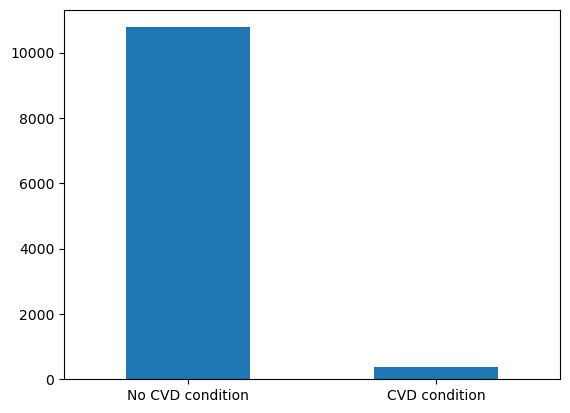

In [13]:
y1['CVD'].value_counts(normalize=True)

CVD_MM = ["No CVD condition" if y1['CVD'].iloc[i] == 0 else "CVD condition" for i in range(y1['CVD'].shape[0])]
CVD_MM = pd.DataFrame(CVD_MM, columns=['CVD'])
CVD_MM['CVD'].value_counts().plot(kind='bar', rot=0)

<Axes: >

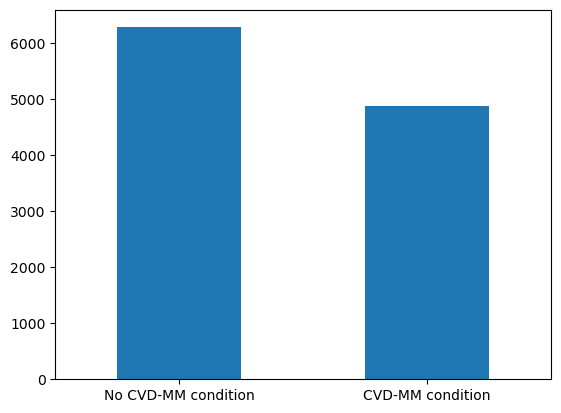

In [14]:
CVD_MM = ["No CVD-MM condition" if y2['CVD_MM'].iloc[i] == 0 else "CVD-MM condition" for i in range(y1['CVD'].shape[0])]
CVD_MM = pd.DataFrame(CVD_MM, columns=['CVD_MM'])
CVD_MM['CVD_MM'].value_counts().plot(kind='bar', rot=0)

## Data preprocessing

### Treat missing values
But first, we revert the pretreated missing values.

In [13]:
dff1 = dff.replace([-999, -222, -111], np.nan).copy()

<Axes: ylabel='Density'>

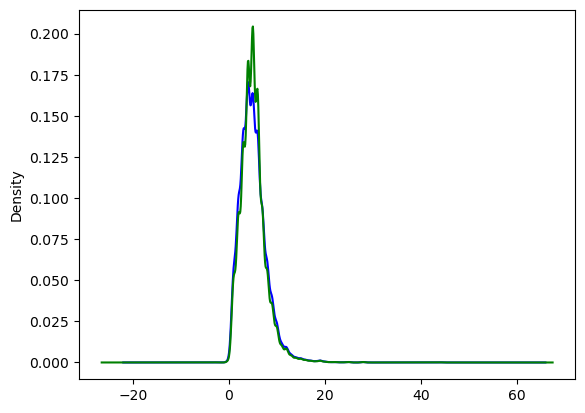

In [16]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff1[predictor_cols])
train_t = imputer.transform(dff1[predictor_cols])
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=dff1[predictor_cols].columns)
treated = treated.apply(np.ceil)

fig = plt.figure()
ax = fig.add_subplot(111)
dff1['number_of_children_c'].plot(kind='kde', ax=ax, color='blue')
treated['number_of_children_c'].plot(kind='kde', ax=ax, color='green')

<Axes: ylabel='Density'>

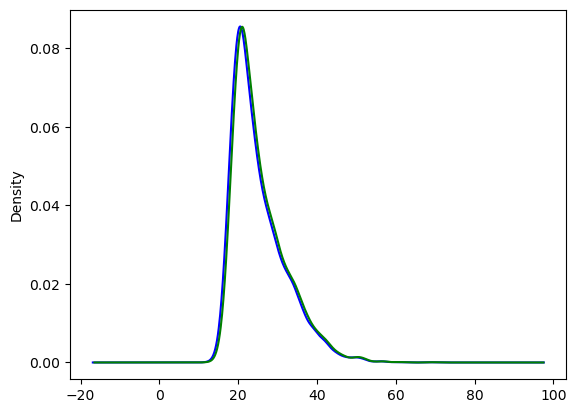

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
dff1['bmi_c_qc'].plot(kind='kde', ax=ax, color='blue')
treated['bmi_c_qc'].plot(kind='kde', ax=ax, color='green')

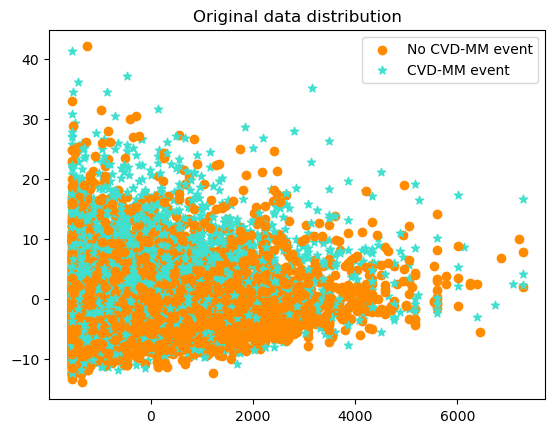

In [18]:
from sklearn.decomposition import PCA
import pylab as pl
pca = PCA(n_components=2).fit(treated[predictor_cols])
pca_2d = pca.transform(treated[predictor_cols])
y_rs = y2['CVD_MM']
pca_2d 
for i in range(0, dff1.shape[0]):
    if y_rs[i] == 0:
      c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='darkorange', marker='o')
    elif y_rs[i] == 1:
      c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='turquoise', marker='*')  
pl.legend([c1, c2], ['No CVD-MM event', 'CVD-MM event'])
pl.title('Original data distribution')
# pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
pl.show()

NearestNeighbours Clearning Rule undersampling Counter({1: 4872, 0: 2968})


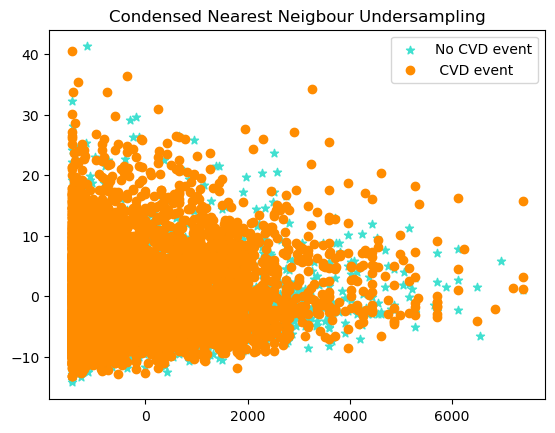

In [17]:
from imblearn.under_sampling import CondensedNearestNeighbour
from collections import Counter
sampler = CondensedNearestNeighbour() 
X_rs, y_rs = sampler.fit_resample(treated[predictor_cols], y2['CVD_MM'])
print('NearestNeighbours Clearning Rule undersampling {}'.format(Counter(y_rs)))
pca = PCA(n_components=2).fit(X_rs)
pca_2d = pca.transform(X_rs)
# y_rs = y1['CVD']
pca_2d 
for i in range(0, pca_2d.shape[0]):
    if y_rs[i] == 1:
      c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='darkorange', marker='o')
    elif y_rs[i] == 0:
      c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='turquoise', marker='*')  
pl.legend([c2, c1], ['No CVD event', ' CVD event'])
pl.title('Condensed Nearest Neigbour Undersampling')
# pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
pl.show()

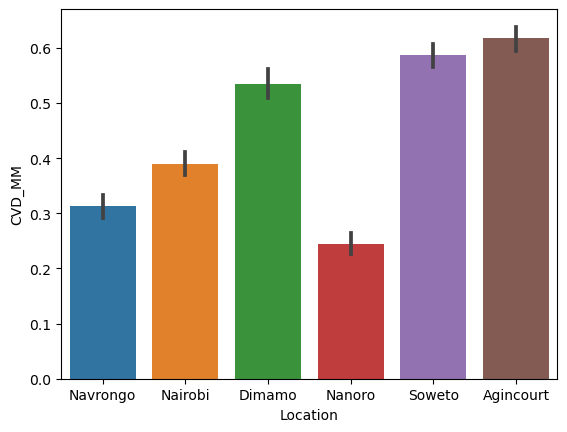

In [19]:
map_dict = {1: "Agincourt", 2: "Dimamo", 3: "Nairobi", 4: "Nanoro", 5: "Navrongo", 6: "Soweto"}
dff1["Location"] = dff1["site"].map(map_dict)
dff1 = dff1.reset_index()
check = pd.concat([y2,dff1.loc[:,'Location']],axis=1)
sns.barplot(x="Location", y="CVD_MM", data=check, errorbar=('ci', 95));

<Axes: xlabel='CVD_MM', ylabel='Density'>

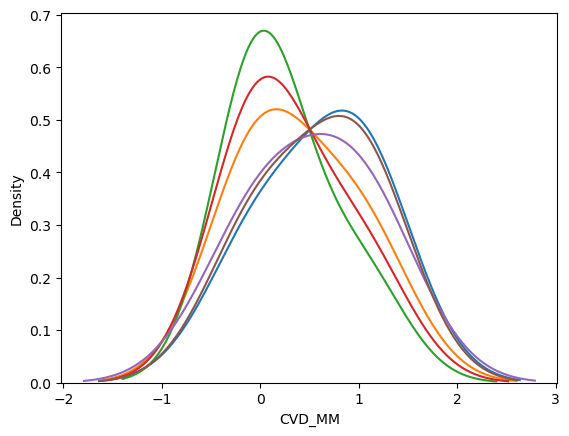

In [20]:
# map_dict = {1: "Agincourt", 2: "Dimamo", 3: "Nairobi", 4: "Nanoro", 5: "Navrongo", 6: "Soweto"}
# dff1["Location"] = dff1["site"].map(map_dict)
# check = pd.concat([y2,dff1.loc[:,'Location']],axis=1)
agincourt_dff = check[(check['Location'] == 'Agincourt')]
nairobi_dff = check[(check['Location'] == 'Nairobi')]
Nanoro_dff = check[(check['Location'] == 'Nanoro')]
Navrongo_dff = check[(check['Location'] == 'Navrongo')]
Dimamo_dff = check[(check['Location'] == 'Dimamo')]
Soweto_dff = check[(check['Location'] == 'Soweto')]
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.legend(['d', 'r', 'rr', 'yr', 'ew', 'wr'])
# agincourt_dff.plot(kind='kde', ax=ax, color='blue')
# nairobi_dff.plot(kind='kde', ax=ax, color='green')
# Nanoro_dff.plot(kind='kde', ax=ax, color='red')
# Navrongo_dff.plot(kind='kde', ax=ax, color='yellow')
# Dimamo_dff.plot(kind='kde', ax=ax, color='black')
# Soweto_dff.plot(kind='kde', ax=ax, color='brown')
sns.kdeplot(data=agincourt_dff, x = 'CVD_MM', bw_adjust=5, legend = 'AG')
sns.kdeplot(data=nairobi_dff, x = 'CVD_MM', bw_adjust=5)
sns.kdeplot(data=Nanoro_dff, x = 'CVD_MM', bw_adjust=5)
sns.kdeplot(data=Navrongo_dff, x = 'CVD_MM', bw_adjust=5)
sns.kdeplot(data=Dimamo_dff, x = 'CVD_MM', bw_adjust=5)
sns.kdeplot(data=Soweto_dff, x = 'CVD_MM', bw_adjust=5)

In [22]:
agincourt_dff

CVD_MM   Location
22          0  Agincourt
28          1  Agincourt
30          0  Agincourt
40          1  Agincourt
46          0  Agincourt
...       ...        ...
11139       1  Agincourt
11141       0  Agincourt
11143       0  Agincourt
11148       0  Agincourt
11149       0  Agincourt

[1753 rows x 2 columns]

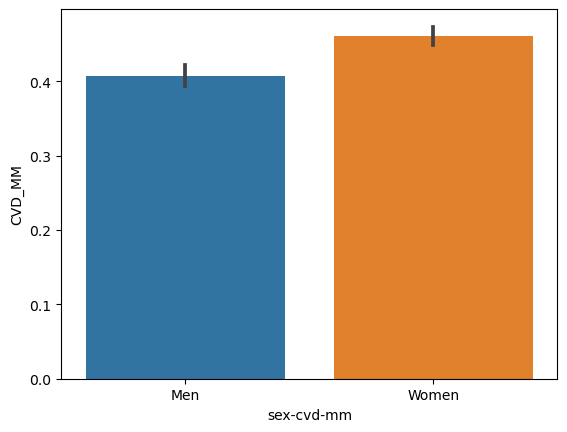

In [21]:
map_dict = {0: "Women", 1: "Men"}
dff1["sex-cvd-mm"] = dff1["sex"].map(map_dict)
check = pd.concat([y2,dff1.loc[:,'sex-cvd-mm']],axis=1)
sns.barplot(x="sex-cvd-mm", y="CVD_MM", data=check, errorbar=('ci', 95));
# sns.barplot(x="sex", y="cadiovascular_current", data=dff, errorbar=('ci', 95));

In [23]:
dff1['CVD_MM'] = y2


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Axes: >

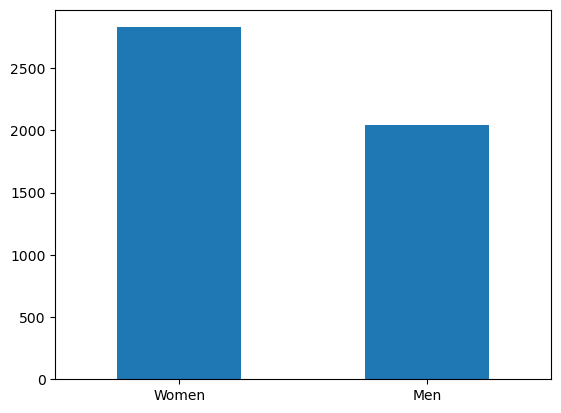

In [24]:
cvd_sex = dff1.loc[dff1['CVD_MM'] == 1]
cvd_sex["sex_label"] = cvd_sex["sex"].map(map_dict)
cvd_sex['sex_label'].value_counts().plot(kind='bar', rot=0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


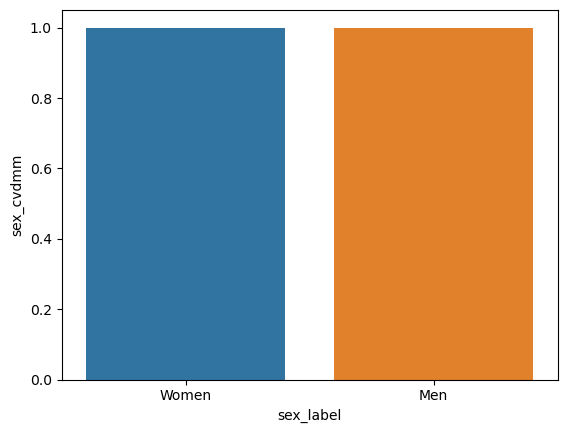

In [26]:
cvd_sex = dff1.loc[dff1['CVD_MM'] == 1]
cvd_sex["sex_cvdmm"] = y2.loc[y2['CVD_MM'] == 1]
cvd_sex["sex_label"] = cvd_sex["sex"].map(map_dict)
cvd_sex = cvd_sex.reset_index()
sns.barplot(x="sex_label", y="sex_cvdmm", data=cvd_sex, errorbar=('ci', 95));

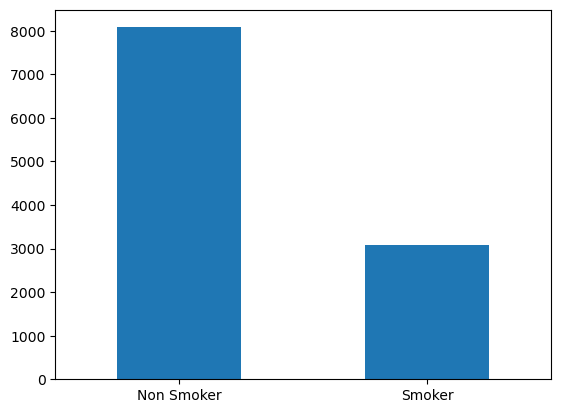

In [29]:
Smoke = ["Non Smoker" if dff1['smoking_status_c_qc'].iloc[i] == 0 else "Smoker" for i in range(y2['CVD_MM'].shape[0])]
Smoke = pd.DataFrame(Smoke, columns=['Smoke'])
Smoke['Smoke'].value_counts().plot(kind='bar', rot=0)
del Smoke

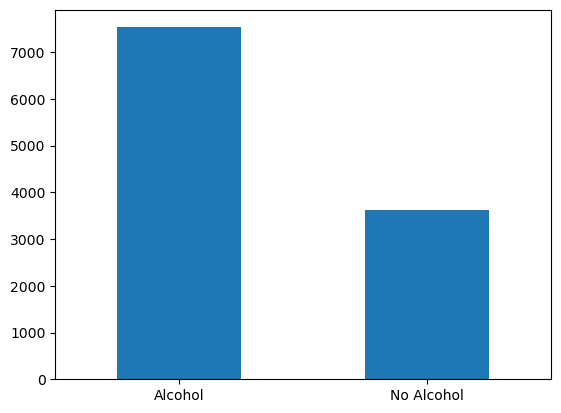

In [30]:
Alco = ["No Alcohol" if dff1['alcohol_use_status_c_qc'].iloc[i] == 0 else "Alcohol" for i in range(y2['CVD_MM'].shape[0])]
Alco = pd.DataFrame(Alco, columns=['Alco'])
Alco['Alco'].value_counts().plot(kind='bar', rot=0)
del Alco

### Data preporcessing

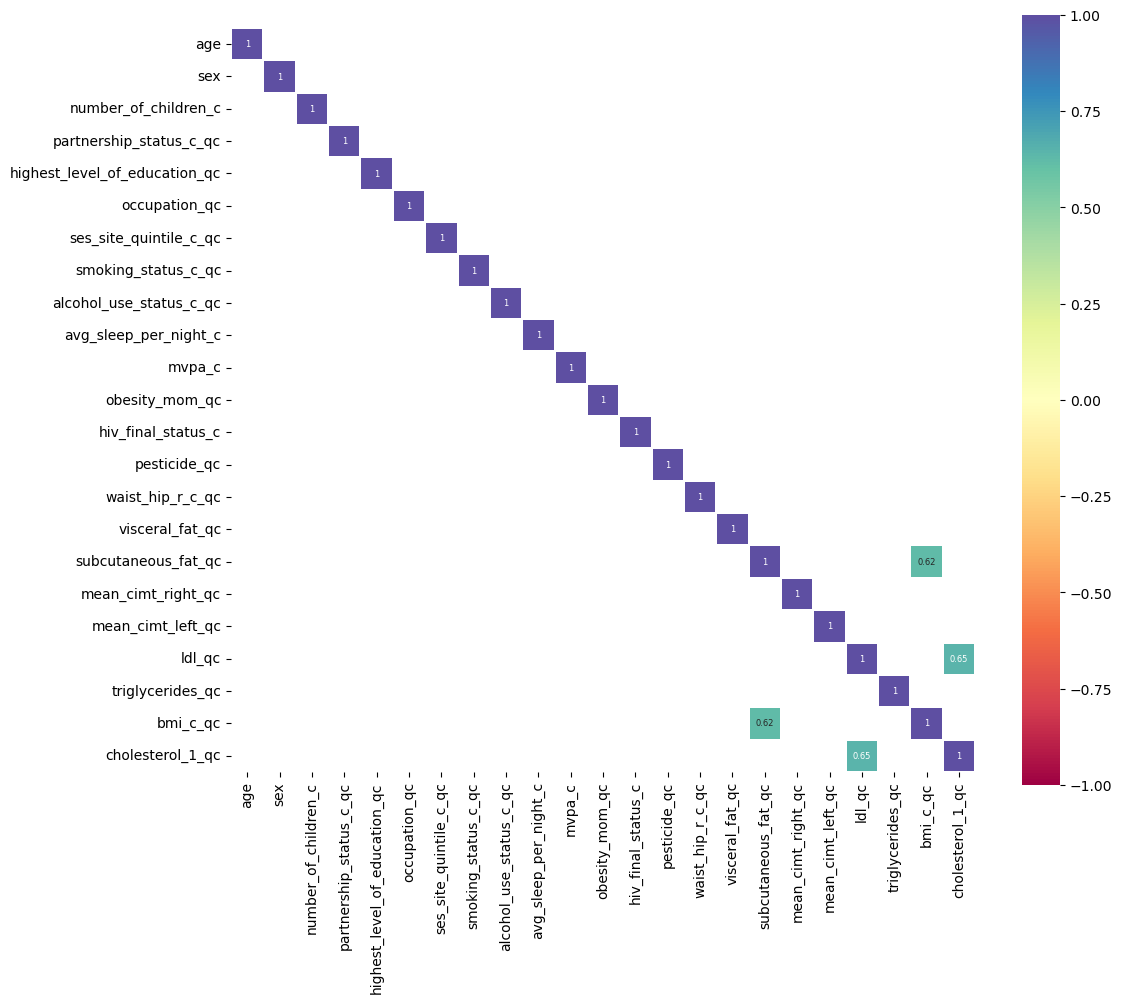

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify correlated variables using correlation coefficients
correlation_matrix = treated[predictor_cols].corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]


plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix[(correlation_matrix >= 0.5) | (correlation_matrix <= -0.4)], 
            cmap='Spectral', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 6}, square=True);

In [26]:
# Remove highly correlated variables
# predictor_cols = ['bmi_c_qc', 'age', 'cimt_mean_max', 'cholesterol_1_qc',
#        'friedewald_ldl_c_c_qc', 'hdl_qc', 'triglycerides_qc',
#        'waist_hip_r_c_qc', 'waist_circumference_qc', 'visceral_fat_qc',
#        'subcutaneous_fat_qc', 'sex', 'hiv_final_status_c',
#        'highest_level_of_education_qc', 'partnership_status_c_qc',
#        'ses_site_quintile_c_qc', 'occupation_qc', 'mvpa_cat_c',
#        'alcohol_use_status_c_qc', 'smoking_status_c_qc']
predictors = [predictor for predictor in predictor_cols if predictor not in highly_correlated]

# Calculate VIF to check for multicollinearity
# X = data[predictors]
# vif = pd.DataFrame()
# vif['Feature'] = X.columns
# vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# # Remove variables with high VIF (> 10)
# predictors = [predictor for predictor in predictors if predictor not in vif[vif['VIF'] > 10]['Feature']]
print(predictor_cols)
print(predictors)

['age', 'sex', 'number_of_children_c', 'partnership_status_c_qc', 'highest_level_of_education_qc', 'occupation_qc', 'ses_site_quintile_c_qc', 'smoking_status_c_qc', 'alcohol_use_status_c_qc', 'avg_sleep_per_night_c', 'mvpa_c', 'obesity_mom_qc', 'hiv_final_status_c', 'pesticide_qc', 'waist_hip_r_c_qc', 'visceral_fat_qc', 'subcutaneous_fat_qc', 'mean_cimt_right_qc', 'mean_cimt_left_qc', 'ldl_qc', 'triglycerides_qc', 'bmi_c_qc', 'cholesterol_1_qc']
['age', 'sex', 'number_of_children_c', 'partnership_status_c_qc', 'highest_level_of_education_qc', 'occupation_qc', 'ses_site_quintile_c_qc', 'smoking_status_c_qc', 'alcohol_use_status_c_qc', 'avg_sleep_per_night_c', 'mvpa_c', 'obesity_mom_qc', 'hiv_final_status_c', 'pesticide_qc', 'waist_hip_r_c_qc', 'visceral_fat_qc', 'subcutaneous_fat_qc', 'mean_cimt_right_qc', 'mean_cimt_left_qc', 'ldl_qc', 'triglycerides_qc', 'bmi_c_qc', 'cholesterol_1_qc']


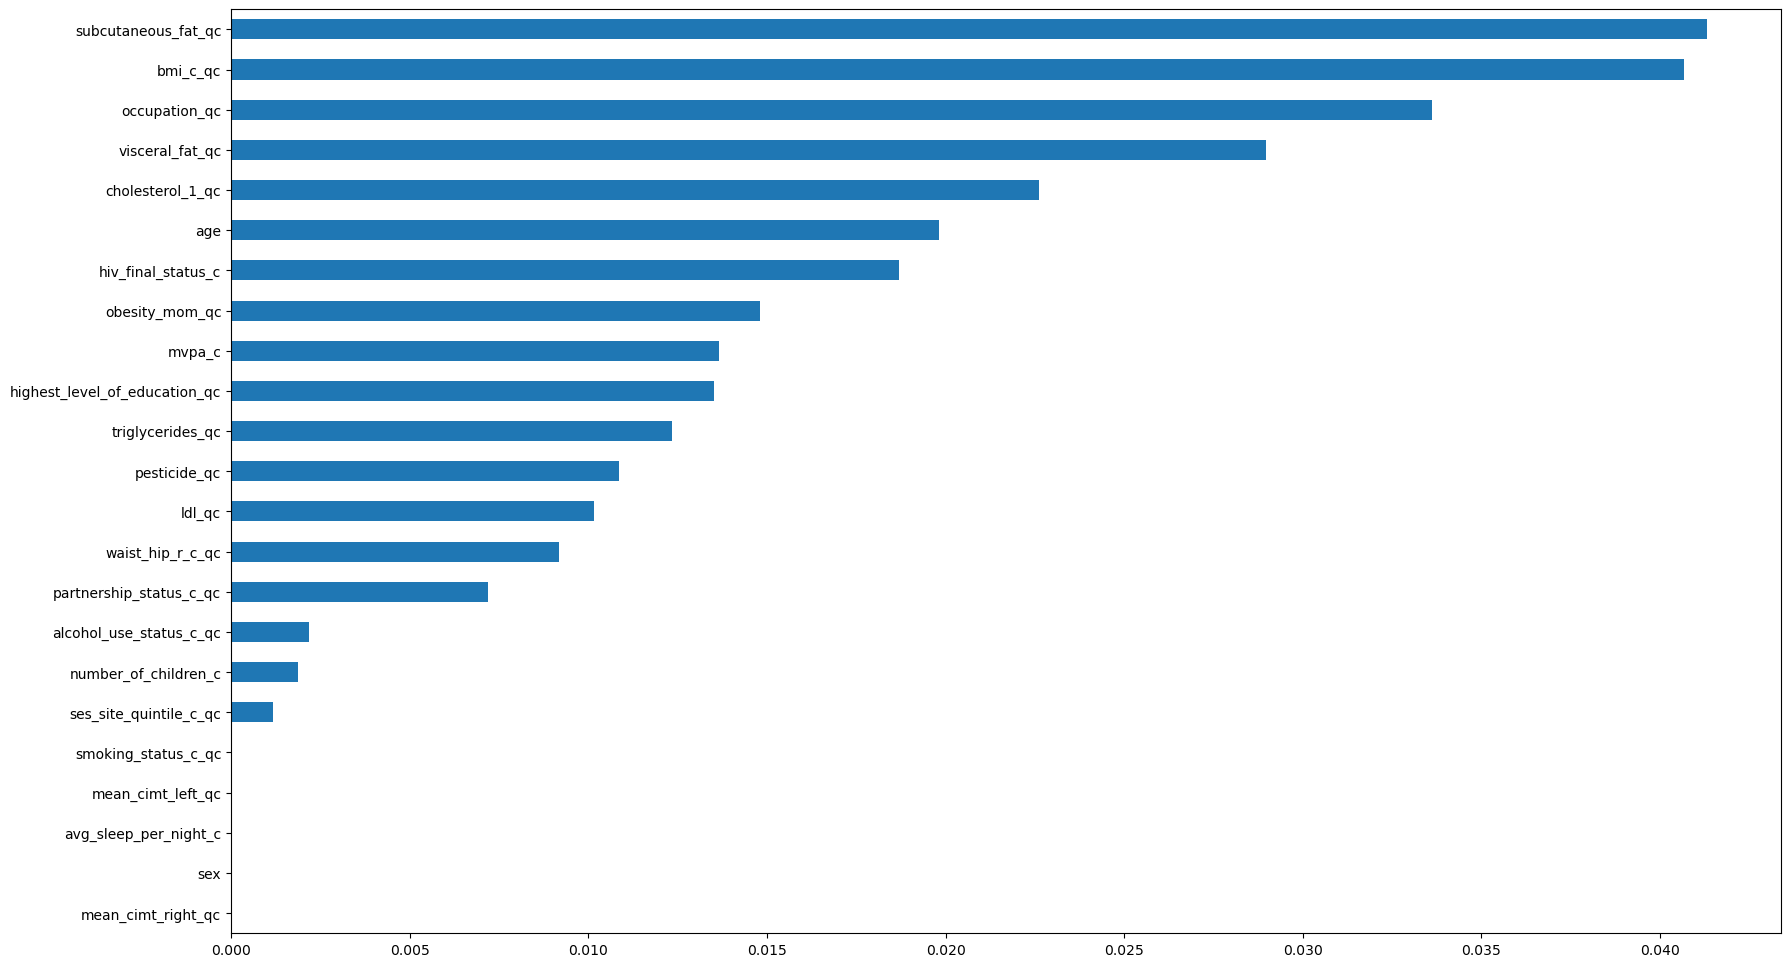

In [27]:
from sklearn.feature_selection import mutual_info_classif
## First, treat missing values before execution
# X = treated.values
X = treated[predictors].values
y = y2['CVD_MM'].values
importance = mutual_info_classif(X,y)
# feat_importance = pd.Series(importance, treated.columns[0:len(data.columns)-1])
feat_importance = pd.Series(importance, treated[predictors].columns[0:len(treated[predictors].columns)-0])
ff = feat_importance.sort_values(ascending=True)
plt.figure(figsize=(20,12))
ff.plot(kind='barh')
plt.show()

## Model development

In [28]:
XGB_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("XGBoost", xgb.XGBClassifier())
])

RF_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("RandomForest", RandomForestClassifier())
])

GB_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("RandomForest", GradientBoostingClassifier())
])

LR_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("Logistic_Regression", LogisticRegression(max_iter=1000))
])

In [33]:
# Split the data into train and test sets (stratified by sex)
train_features_bal, test_features_bal, train_targets_bal, test_targets_bal = train_test_split(
    treated[predictors], y2['CVD_MM'], test_size=0.2, stratify=treated[['sex']], random_state=12)

In [34]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=train_targets_bal
)
XGB_pipeline.fit(train_features_bal, train_targets_bal, XGBoost__sample_weight=classes_weights)
RF_pipeline.fit(train_features_bal, train_targets_bal)
LR_pipeline.fit(train_features_bal, train_targets_bal)
GB_pipeline.fit(train_features_bal, train_targets_bal)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('RandomForest', GradientBoostingClassifier())])

In [35]:
Y_pred_proba_XGB = XGB_pipeline.predict_proba(test_features_bal)[:,1]
Y_pred_XGB = XGB_pipeline.predict(test_features_bal)


Y_pred_proba_RF = RF_pipeline.predict_proba(test_features_bal)[:,1]
Y_pred_RF = RF_pipeline.predict(test_features_bal)

Y_pred_proba_LR = LR_pipeline.predict_proba(test_features_bal)[:,1]
Y_pred_LR = LR_pipeline.predict(test_features_bal)

Y_pred_proba_GB = GB_pipeline.predict_proba(test_features_bal)[:,1]
Y_pred_GB = GB_pipeline.predict(test_features_bal)

In [37]:
print('XGB accuracy', roc_auc_score(test_targets_bal, Y_pred_proba_XGB))
print('RF accuracy', roc_auc_score(test_targets_bal, Y_pred_proba_RF))
print('LR accuracy', roc_auc_score(test_targets_bal, Y_pred_proba_LR))
print('GB accuracy', roc_auc_score(test_targets_bal, Y_pred_proba_GB))

XGB accuracy 0.6820356968006124
RF accuracy 0.6968921570762467
LR accuracy 0.7149232435710996
GB accuracy 0.7134673999924184


Text(0, 0.5, 'True Positive rate')

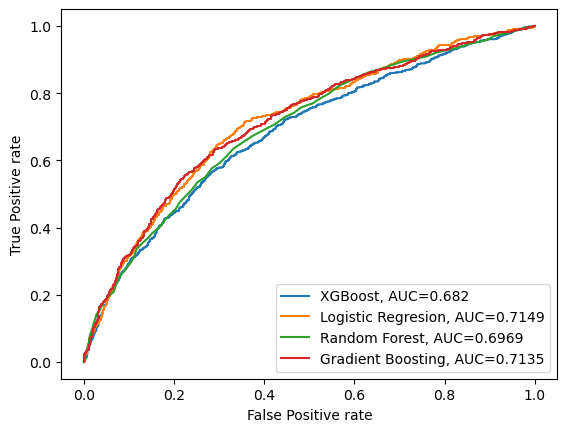

In [38]:
# RocCurveDisplay.from_predictions(test_targets, Y_pred_proba_XGB)
# RocCurveDisplay.from_predictions(test_targets, Y_pred_proba_RF)
# RocCurveDisplay.from_predictions(test_targets, Y_pred_proba_LR)
#set up plotting area

from sklearn import metrics
plt.figure(0).clf()

#fit logistic regression model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(test_targets_bal, Y_pred_proba_XGB)
auc = round(metrics.roc_auc_score(test_targets_bal, Y_pred_proba_XGB), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc))

#fit gradient boosted model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(test_targets_bal, Y_pred_proba_LR)
auc = round(metrics.roc_auc_score(test_targets_bal, Y_pred_proba_LR), 4)
plt.plot(fpr,tpr,label="Logistic Regresion, AUC="+str(auc))

#fit gradient boosted model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(test_targets_bal, Y_pred_proba_RF)
auc = round(metrics.roc_auc_score(test_targets_bal, Y_pred_proba_RF), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit gradient boosted model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(test_targets_bal, Y_pred_proba_GB)
auc = round(metrics.roc_auc_score(test_targets_bal, Y_pred_proba_GB), 4)
plt.plot(fpr,tpr,label="Gradient Boosting, AUC="+str(auc))

#add legend
plt.legend()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")


Text(0, 0.5, 'False Positive rate')

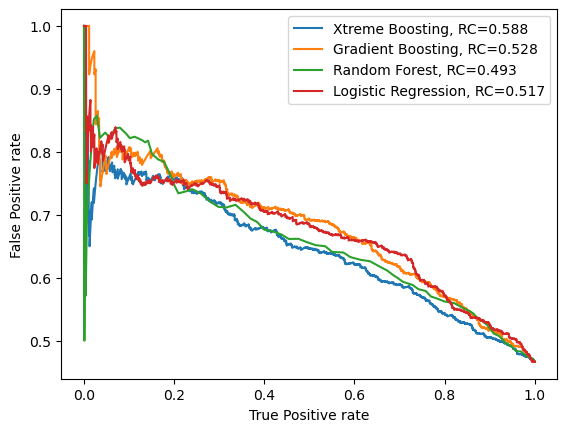

In [39]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
plt.figure(0).clf()
prec, recall, _ = precision_recall_curve(test_targets_bal, Y_pred_proba_XGB, pos_label=XGB_pipeline.classes_[1])
RC = round(recall_score(test_targets_bal, Y_pred_XGB),3)
plt.plot(recall,prec,label="Xtreme Boosting, RC="+str(RC))
# prec, recall, _ = precision_recall_curve(test_targets_bal, Y_pred_proba_RF, pos_label=RF_pipeline.classes_[1])
# pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
prec, recall, _ = precision_recall_curve(test_targets_bal, Y_pred_proba_GB, pos_label=GB_pipeline.classes_[1])
RC = round(recall_score(test_targets_bal, Y_pred_GB),3)
plt.plot(recall,prec,label="Gradient Boosting, RC="+str(RC))
prec, recall, _ = precision_recall_curve(test_targets_bal, Y_pred_proba_RF, pos_label=RF_pipeline.classes_[1])
# pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
RC = round(recall_score(test_targets_bal, Y_pred_RF),3)
plt.plot(recall,prec,label="Random Forest, RC="+str(RC))
prec, recall, _ = precision_recall_curve(test_targets_bal, Y_pred_proba_LR, pos_label=LR_pipeline.classes_[1])
# pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
RC = round(recall_score(test_targets_bal, Y_pred_LR),3)
plt.plot(recall,prec,label="Logistic Regression, RC="+str(RC))

#add legend
plt.legend()
plt.xlabel("True Positive rate")
plt.ylabel("False Positive rate")

In [40]:
balanced_accuracy_score(test_targets_bal, Y_pred_RF)

0.6338871991424637

In [41]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=train_targets_bal
)
modelx = xgb.XGBClassifier()
modelx.fit(train_features_bal,train_targets_bal, sample_weight=classes_weights)
model = RandomForestClassifier()
model.fit(train_features_bal,train_targets_bal, sample_weight=classes_weights)

RandomForestClassifier()

## Human-centered Artificial Intelligence
### Model interpretability

The aim is to explain the ML model in a global and local manner. 

Some tentative questions would be:
* Which feature(s) are the most important for predicting CVD-MM cases?
* Given the prediction of certain participants, what role are the feature(s) playing to achieve such outcome?

To answer the questions, we need to work on the global interpretability of the model - understand how the ML model is predicting CVD-MM outcomes. 

In [42]:
from lime.lime_tabular import LimeTabularExplainer

# Train an interpretable model
interpretable_model = modelx
interpretable_model.fit(train_features_bal, train_targets_bal)

# Create an explainer for LIME
explainer_lime = LimeTabularExplainer(train_features_bal.values, feature_names=train_features_bal.columns, class_names=['No CVD-MM', 'CVD-MM'])

# Choose an instance for explanation
instance_idx = np.random.choice(a=test_features_bal.index, size=1)  # Choose the index of the instance you want to explain
print(instance_idx)
# Generate LIME explanation for the chosen instance
lime_exp = explainer_lime.explain_instance(test_features_bal.iloc[33], interpretable_model.predict_proba, num_features=len(test_features_bal.columns))

# Print the explanation
lime_exp.show_in_notebook(show_table=True)

[2886]


In [40]:
# SHAP Modelling
shap.initjs()
model = xgb.XGBClassifier()
model.fit(test_features_bal, test_targets_bal)
explainer = shap.Explainer(model, test_features_bal)
shap_values = explainer(test_features_bal)

In [41]:
# SHAP Analysis

explainer1 = shap.TreeExplainer(model, train_features_bal)
shap_values1 = explainer1(test_features_bal)

In [42]:
# SHAP Analysis

explainer1 = shap.TreeExplainer(model, train_features_bal)
shap_values1 = explainer1(test_features_bal)

In [43]:
explainer_sexf = shap.Explainer(model, test_features_bal[(test_features_bal['sex'] == 0.0)])
shap_values_sexf = explainer(test_features_bal[(test_features_bal['sex'] == 0.0)])

In [44]:
indices = test_features_bal[(test_features_bal['sex'] == 0.0)].index
# test_features_bal.index

In [45]:
sexf_shap = np.take(shap_values.values, indices)
# sexf_shap = np.where(np.in1d)
sexf = test_features_bal[(test_features_bal['sex'] == 0.0)]

In [89]:
# ttt = test_features_bal
# shap_values.values.shape
# ttt.reset_index(drop=True)


(1228,)

In [46]:
shap_values.shape

(2232, 23)

In [ ]:
# np.where(test_features_bal())
# # np.where(np.in1d(a, b))[0]
# dff = dff[(dff['age'] <= 65) & (dff['age'] >= 40)]

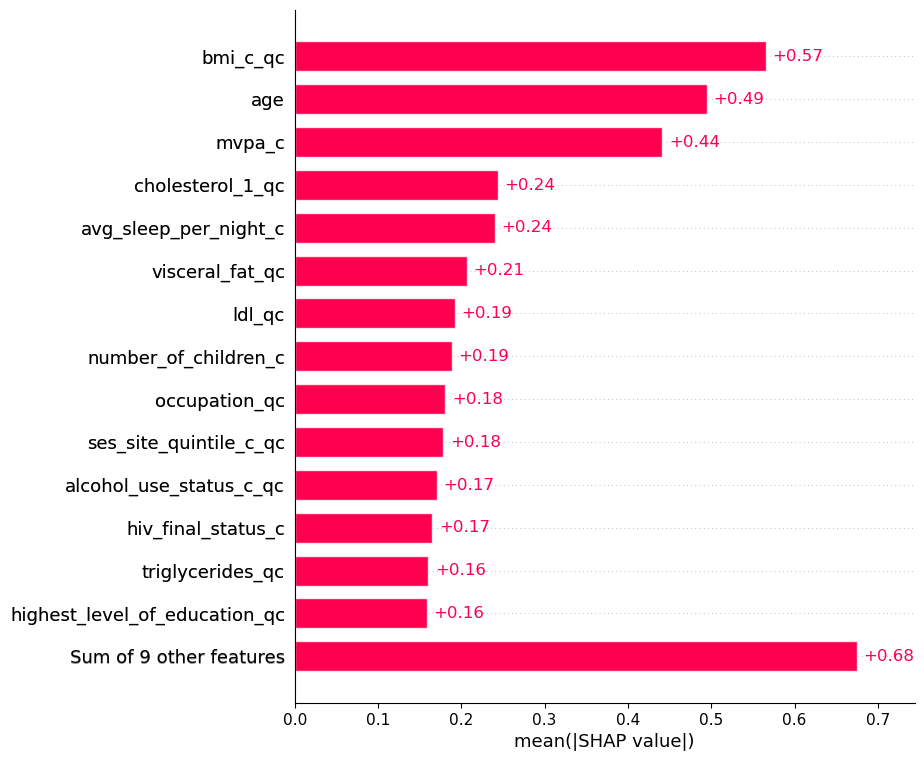

In [47]:
shap.plots.bar(shap_values, max_display=15)

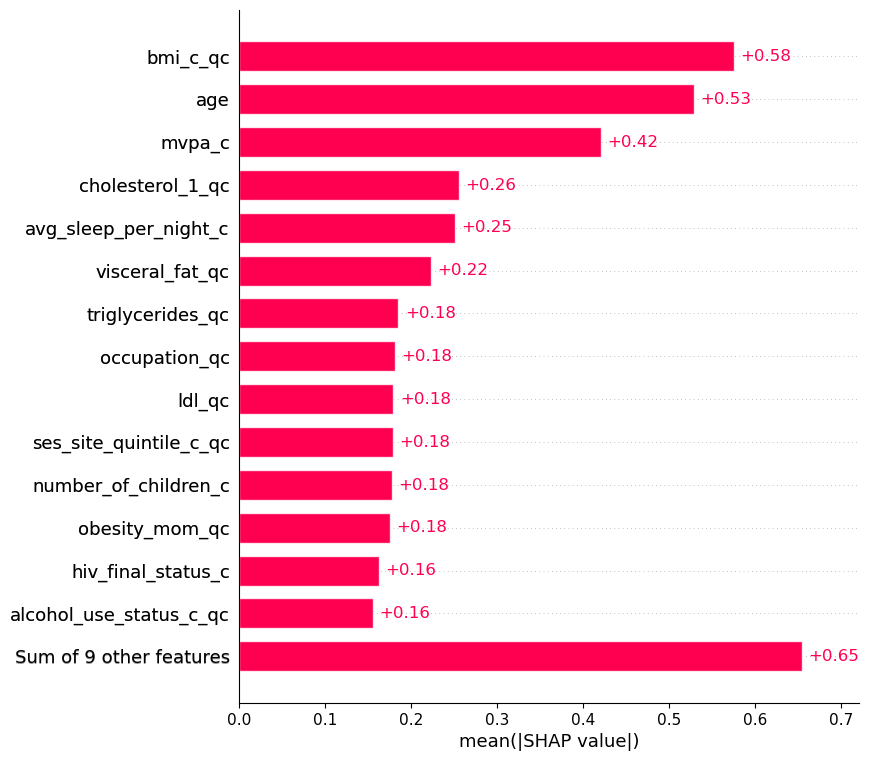

In [48]:
shap.plots.bar(shap_values_sexf, max_display=15)

In [49]:
### Splitting the dataset into CVD cases for cohort expalantion
cohort_exp_CVD = test_features_bal[test_targets_bal == 1]
cohort_exp_noCVD = test_features_bal[test_targets_bal == 0]

# model.fit(test_features_bal, test_targets_bal)
explainercvd = shap.Explainer(model, cohort_exp_CVD)
shap_valuescvd = explainercvd(cohort_exp_CVD)

In [50]:
# model.fit(test_features_bal, test_targets_bal)
explainernocvd = shap.Explainer(model, cohort_exp_noCVD)
shap_valuesnocvd = explainercvd(cohort_exp_noCVD)

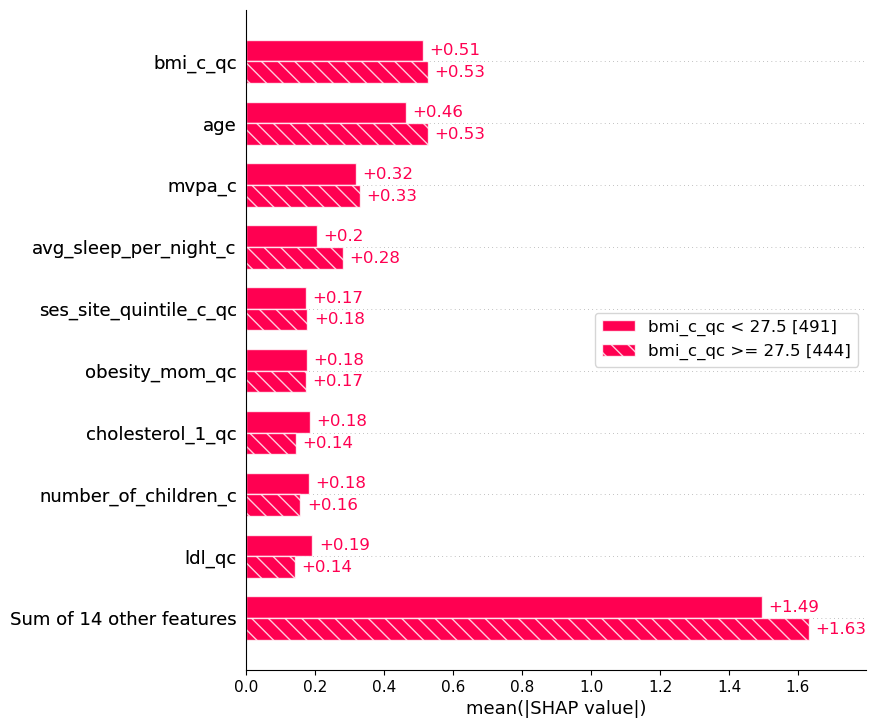

In [51]:
shap.plots.bar(shap_valuescvd.cohorts(2).abs.mean(0))

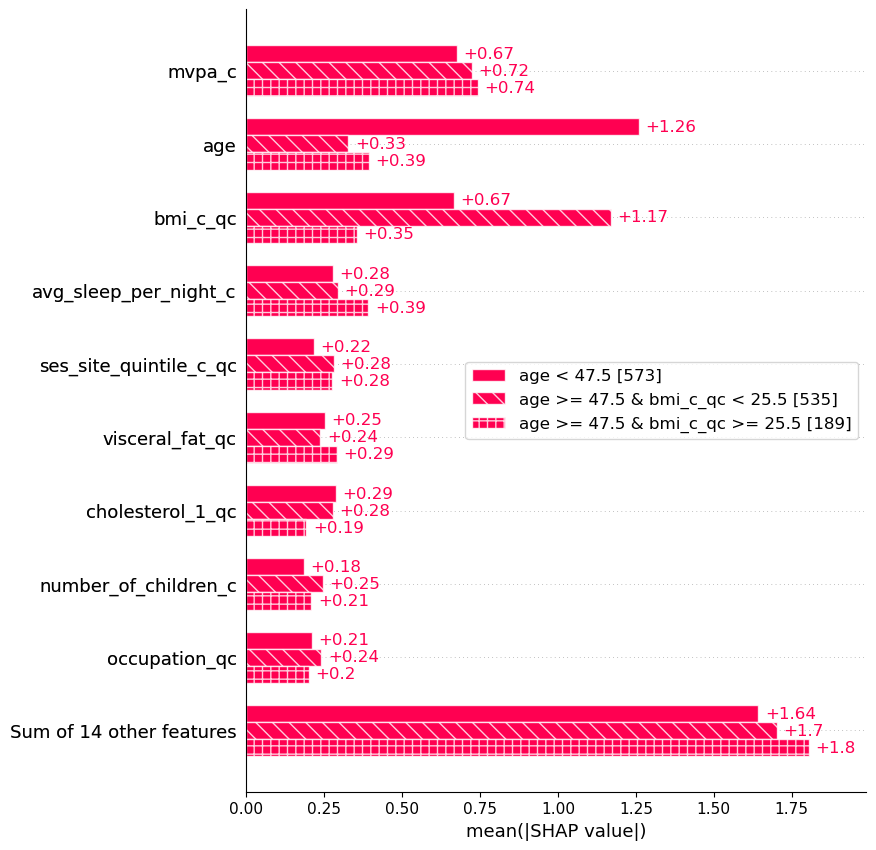

In [52]:
shap.plots.bar(shap_valuesnocvd.cohorts(3).abs.mean(0))

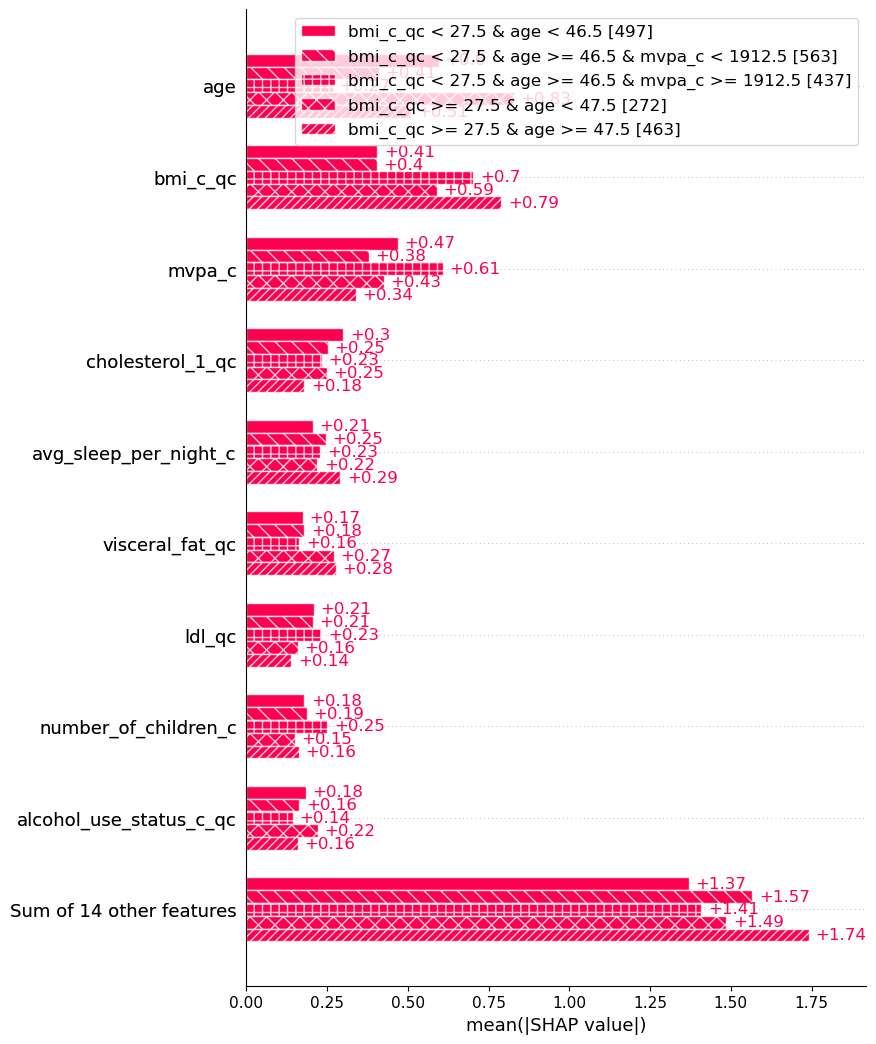

In [53]:
shap.plots.bar(shap_values.cohorts(5).abs.mean(0))

In [54]:
cohort_exp_CVD['sex']

6876     1.0
10813    0.0
104      1.0
10081    1.0
3472     1.0
        ... 
9901     0.0
5636     0.0
3539     0.0
5846     0.0
4208     0.0
Name: sex, Length: 935, dtype: float64

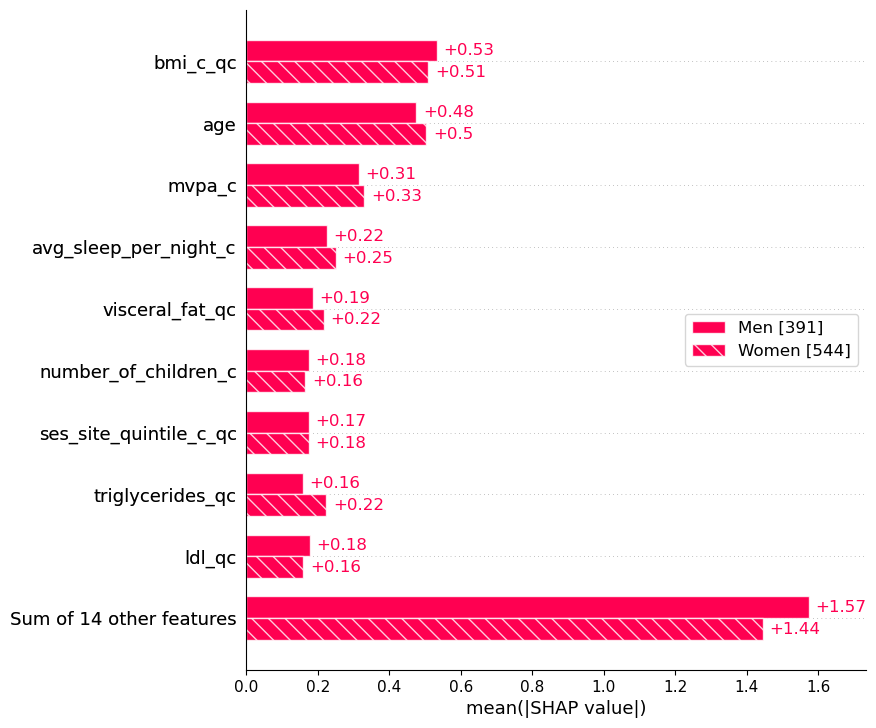

In [55]:
sex = (
    cohort_exp_CVD['sex']
    .apply(lambda sex: 'Women' if sex == 0 else 'Men')
    .values
)
#### do for mid point high-low cholesterol (make for only CVD cases)
shap.plots.bar(shap_valuescvd.cohorts(sex).abs.mean(axis=0))

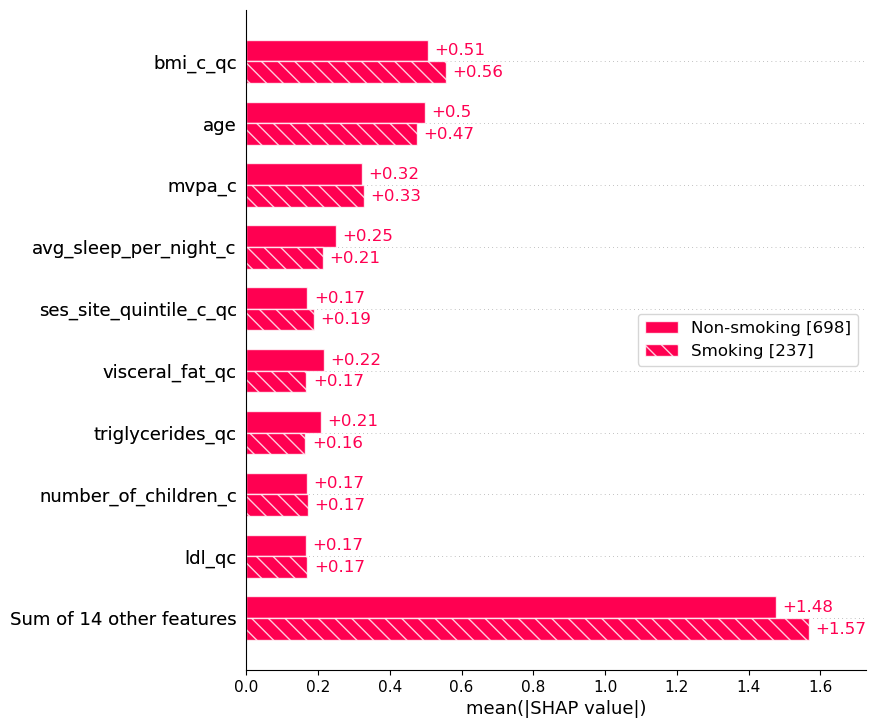

In [56]:
smoke = (
    cohort_exp_CVD['smoking_status_c_qc']
    .apply(lambda sex: 'Non-smoking' if sex == 0 else 'Smoking')
    .values
)
#### do for mid point high-low cholesterol (make for only CVD cases)
shap.plots.bar(shap_valuescvd.cohorts(smoke).abs.mean(axis=0))

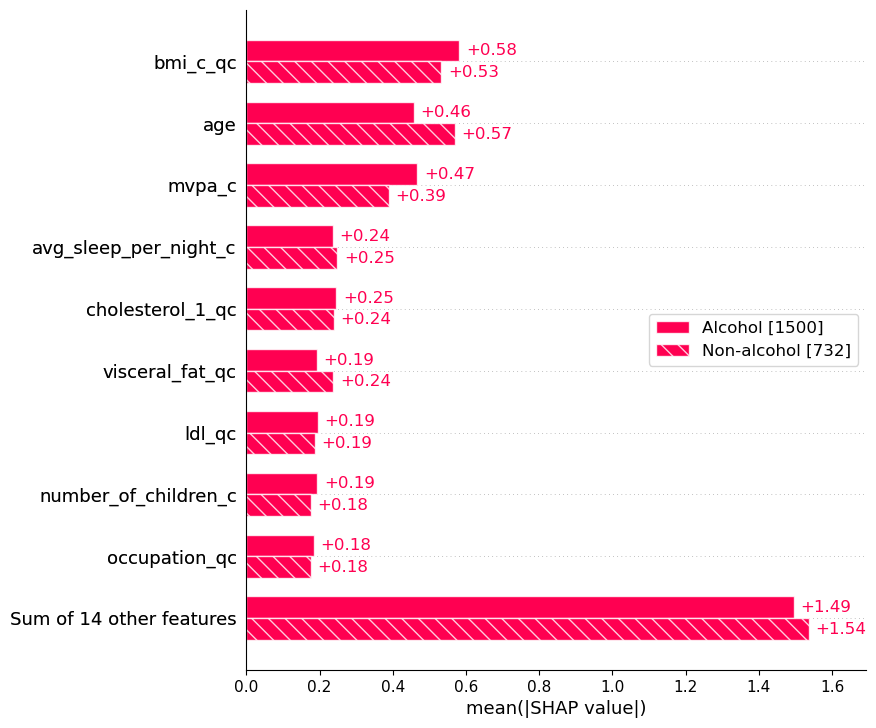

In [57]:
smoke = (
    test_features_bal['alcohol_use_status_c_qc']
    .apply(lambda sex: 'Non-alcohol' if sex == 0 else 'Alcohol')
    .values
)
#### do for mid point high-low cholesterol (make for only CVD cases)
shap.plots.bar(shap_values.cohorts(smoke).abs.mean(axis=0))

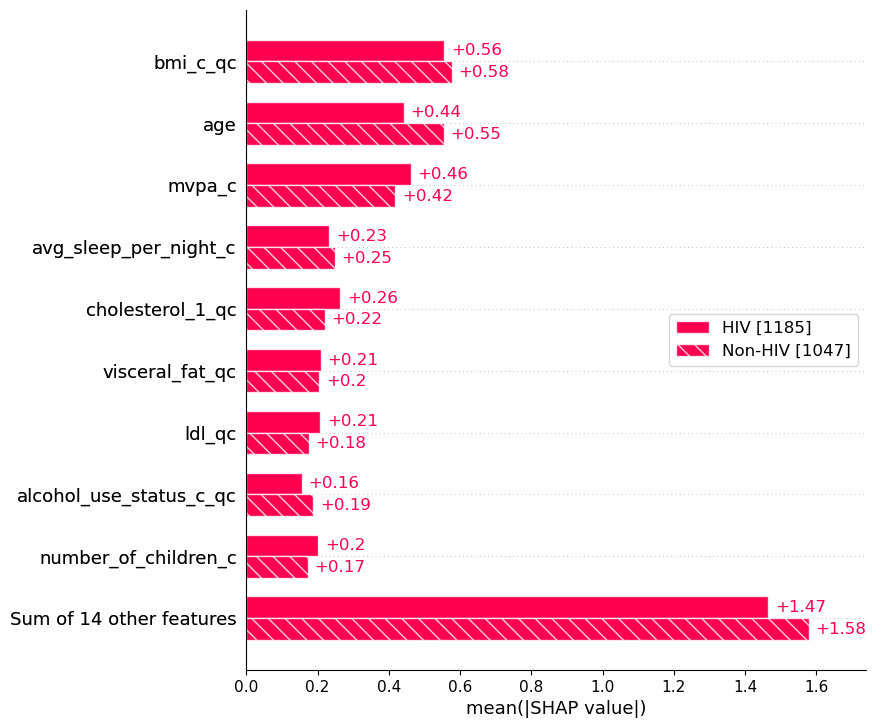

In [58]:
smoke = (
    test_features_bal['hiv_final_status_c']
    .apply(lambda sex: 'Non-HIV' if sex == 0 else 'HIV')
    .values
)
#### do for mid point high-low cholesterol (make for only CVD cases)
shap.plots.bar(shap_values.cohorts(smoke).abs.mean(axis=0))

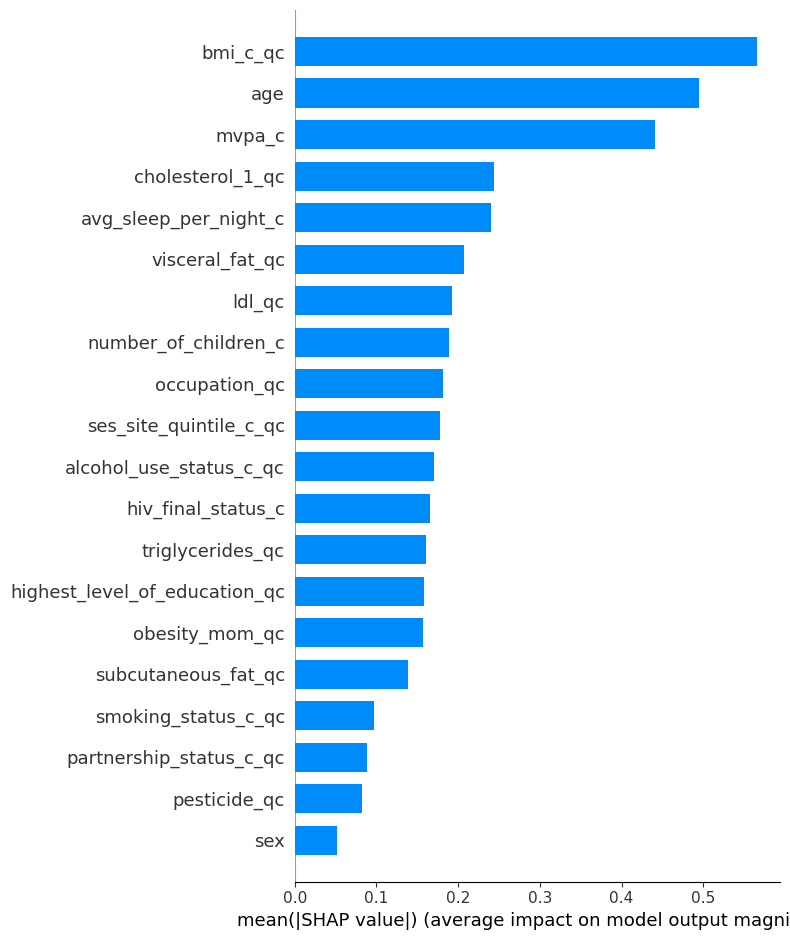

In [59]:
shap.summary_plot(shap_values, plot_type = 'bar' )

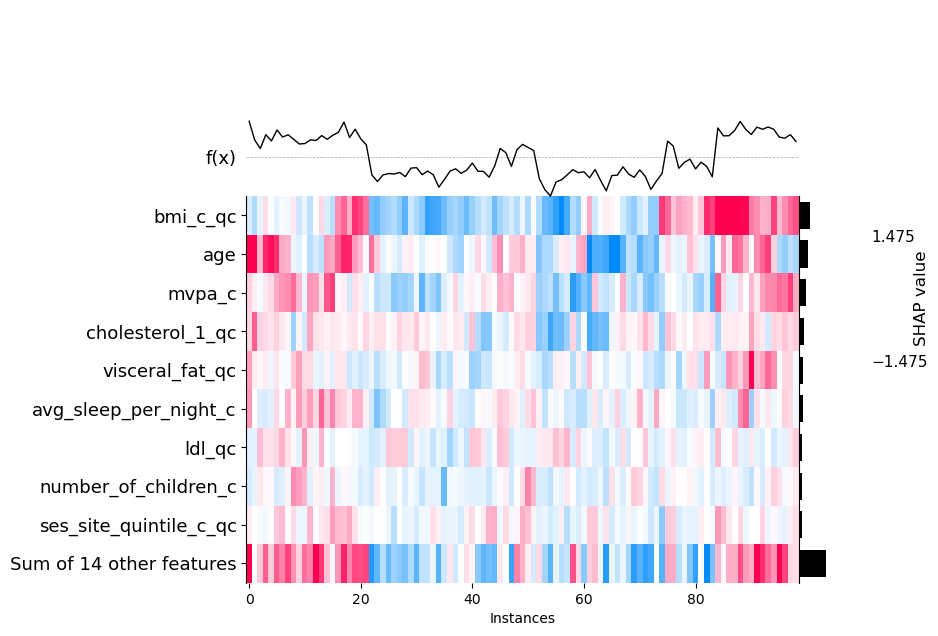

In [60]:
shap.plots.heatmap(shap_values[1:100]) # Do for random instances - np.random.choice

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


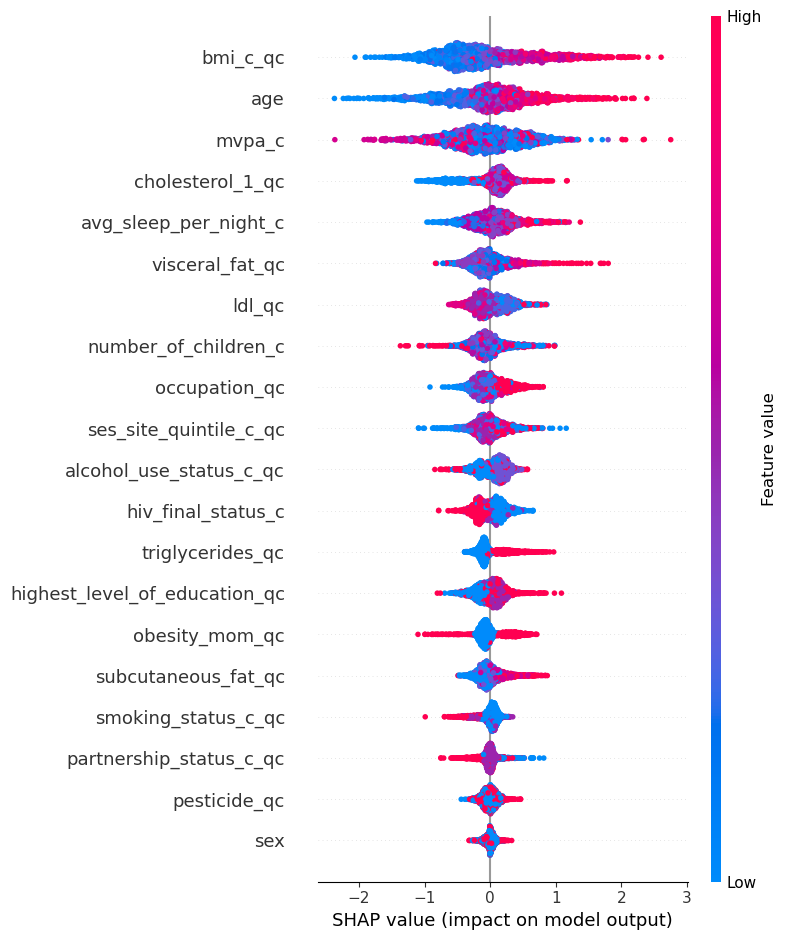

In [61]:
shap.summary_plot(shap_values, test_features_bal, feature_names = test_features_bal.columns)

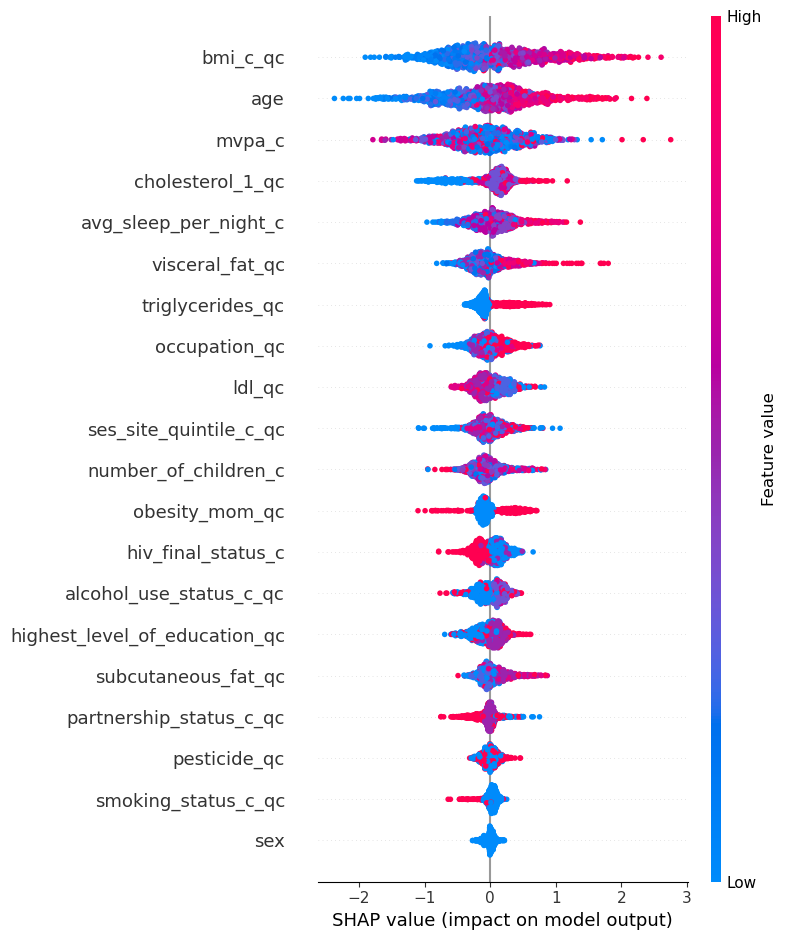

In [62]:
shap.summary_plot(shap_values_sexf, test_features_bal[(test_features_bal['sex'] == 0.0)], feature_names = test_features_bal.columns)

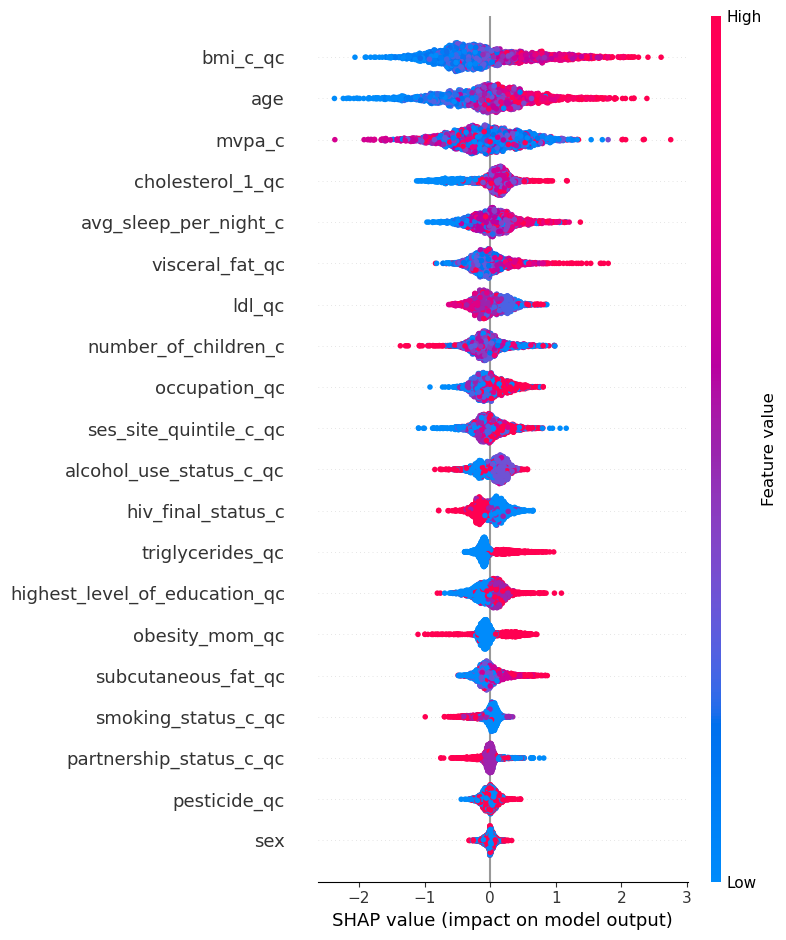

In [63]:
shap.summary_plot(shap_values, test_features_bal, feature_names = test_features_bal.columns)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


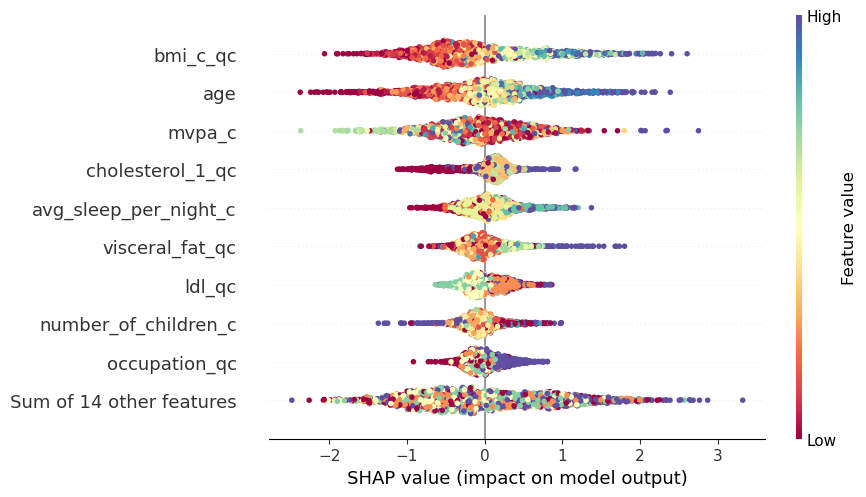

In [64]:
shap.plots.beeswarm(shap_values, color=plt.get_cmap("Spectral"))

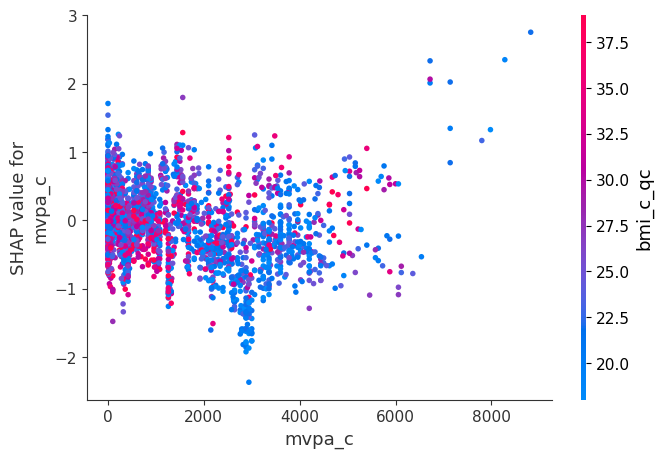

In [65]:
shap.dependence_plot("mvpa_c", shap_values.values, test_features_bal)

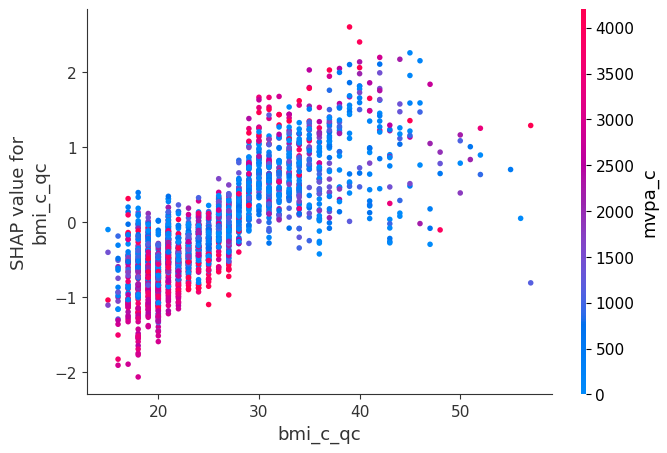

In [66]:
shap.dependence_plot("bmi_c_qc", shap_values.values, test_features_bal, color='transparent_blue')

## Explaining the local interpretability

In [67]:
test_features_bal.mean()

age                                50.303763
sex                                 0.449821
number_of_children_c                5.081541
partnership_status_c_qc             1.185484
highest_level_of_education_qc       0.991935
occupation_qc                       2.131272
ses_site_quintile_c_qc              3.186380
smoking_status_c_qc                 0.383513
alcohol_use_status_c_qc             1.008065
avg_sleep_per_night_c               8.495968
mvpa_c                           1532.361559
obesity_mom_qc                      0.327509
hiv_final_status_c                  0.929659
pesticide_qc                        0.527778
waist_hip_r_c_qc                    1.050627
visceral_fat_qc                     5.670251
subcutaneous_fat_qc                 2.114247
mean_cimt_right_qc                  1.008065
mean_cimt_left_qc                   1.010753
ldl_qc                              2.904122
triglycerides_qc                    1.364695
bmi_c_qc                           25.805556
cholestero

In [ ]:
negative_ids = train[Y_train == 0].index
positive_ids = Y_train[Y_train == 1].index
balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

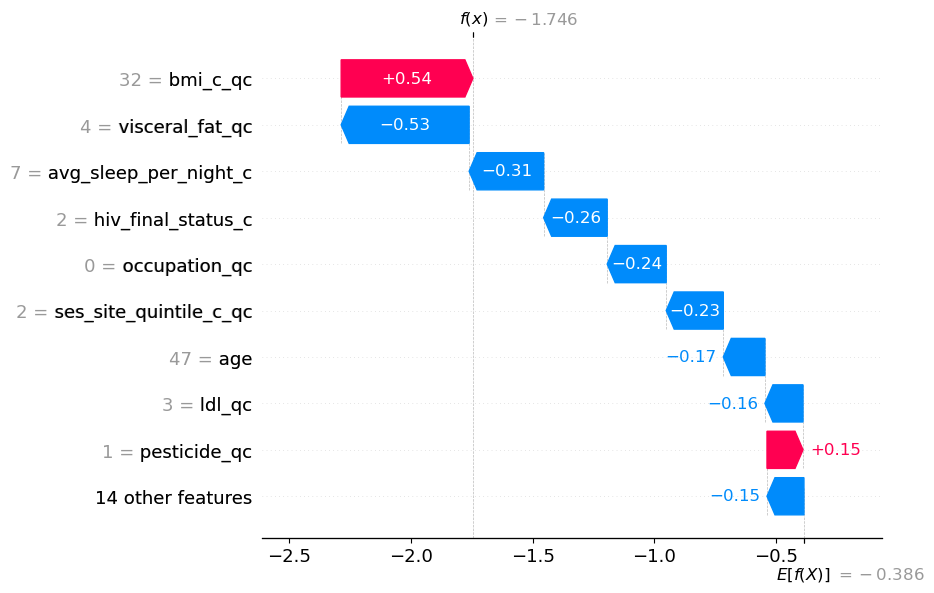

In [68]:
shap.plots.waterfall(shap_values[1])

A waterfall plot powerfully shows why a case receives its prediction given its variable values. You start with the bottom of a waterfall plot and add (red) or subtract (blue) the values to get to the final prediction. The graph below shows the prediction for the fifth observation in predictor values. It starts with the **base value** of `-0.296` at the bottom, which is the average of all observations. The model prediction for Observation 1 is `-1.199`, as shown on the top. Why is it `-1.199`? Here: $-0.296\text{(base value)}+0.11-0.09-0.09-0.1-0.1-0.13+0.16-0.19+0.23-0.71 =$ `-1.199`.

There are values next to the variable names. Those are the values of the variables. For example, the value of ACR for the second observation is `8`. Is 8 good, if compared with all other patients with different ACR? Remember the SHAP model is built on the training data set. The mean values of the variables can be obtained by X_train.mean(). 

The average "BMI" for all participants is `25.77` and the second observation is `18`. Because the ''BMI'' level contributes negatively to the CVD prediction, but the BMI of Observation 2 is higher than the average, hence the BMI value of this patient contributes negatively to its prediction by $18$ as shown above.

In [77]:
explainer5 = shap.TreeExplainer(model)
shap_values5 = explainer5.shap_values(test_features_bal)
# shap.initjs()
def local_explainer(j):
    return(shap.force_plot(explainer.expected_value, shap_values5[j,:], test_features_bal.iloc[j,:]))
def local_explainer_logit(j):
    return(shap.force_plot(explainer.expected_value, shap_values5[j,:], test_features_bal.iloc[j,:], link='logit'))

In [78]:
# Non-CVD case
local_explainer(7)

In [79]:
# Non-CVD case
local_explainer_logit(7)

In [82]:
# Non-CVD case
local_explainer_logit(22)

In [84]:
# CVD case
local_explainer_logit(34)

In [85]:
# CVD case
local_explainer_logit(30)

In [86]:
# CVD case
local_explainer_logit(4)

In [90]:
test_targets_bal.iloc[34]

0

In [97]:
select = range(20)
features = test_features_bal.iloc[select]
features.columns

Index(['age', 'sex', 'number_of_children_c', 'partnership_status_c_qc',
       'highest_level_of_education_qc', 'occupation_qc',
       'ses_site_quintile_c_qc', 'smoking_status_c_qc',
       'alcohol_use_status_c_qc', 'avg_sleep_per_night_c', 'mvpa_c',
       'obesity_mom_qc', 'hiv_final_status_c', 'pesticide_qc',
       'waist_hip_r_c_qc', 'visceral_fat_qc', 'subcutaneous_fat_qc',
       'mean_cimt_right_qc', 'mean_cimt_left_qc', 'ldl_qc', 'triglycerides_qc',
       'bmi_c_qc', 'cholesterol_1_qc'],
      dtype='object')

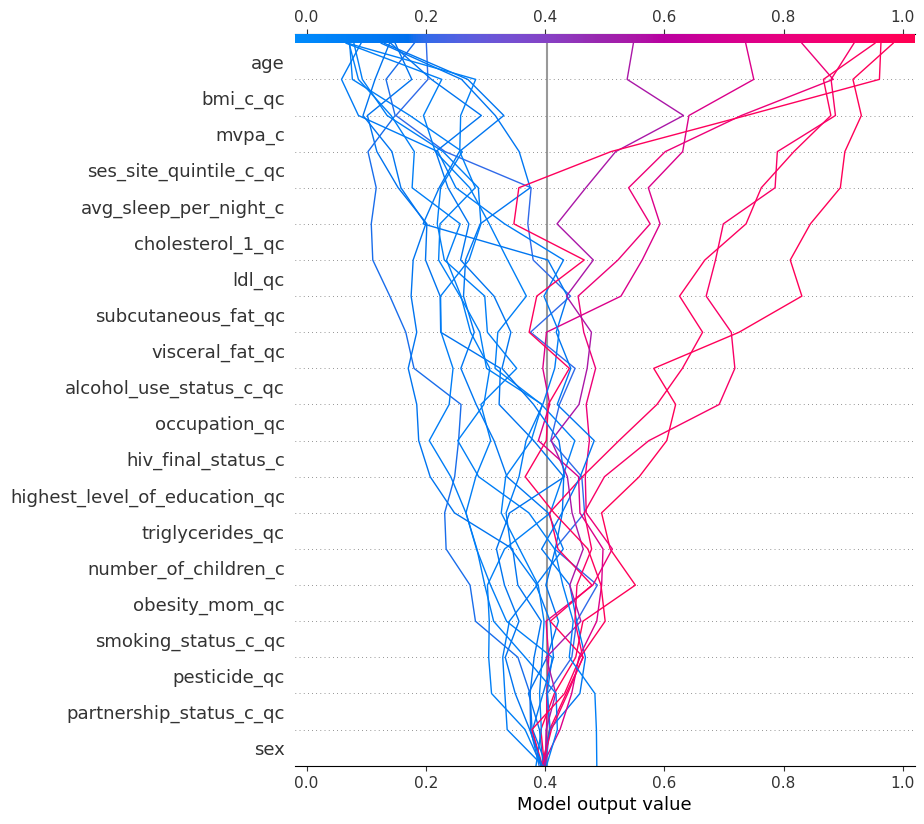

In [118]:
shap.decision_plot(explainer5.expected_value, shap_values5[select,:], features.columns, link='logit')

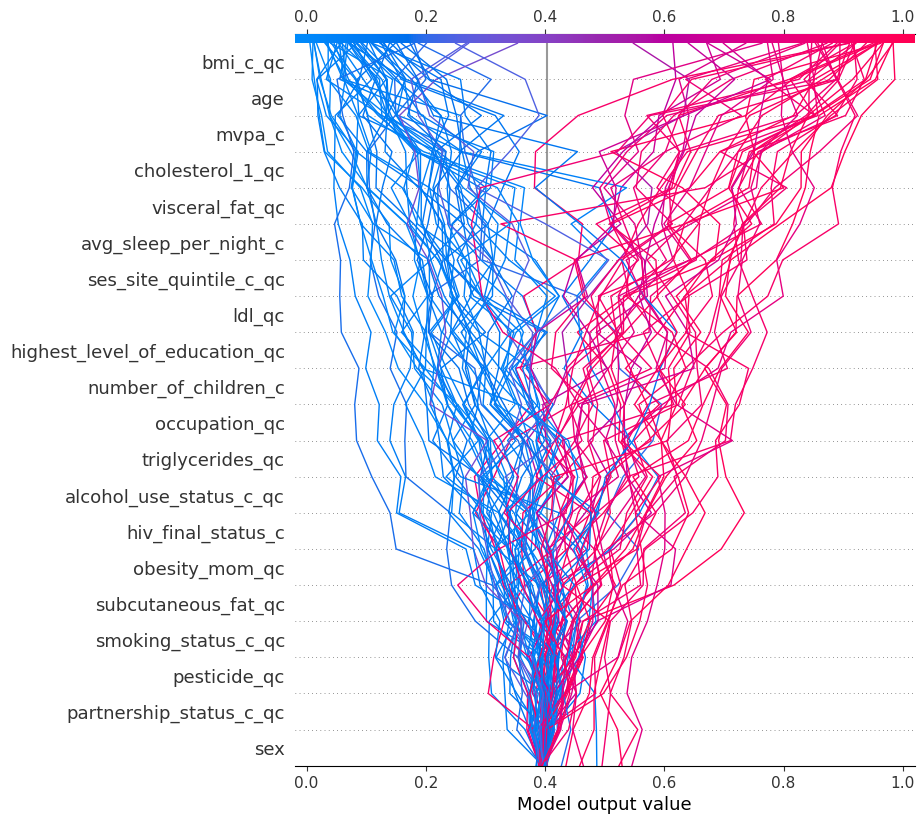

In [150]:
# Our naive cutoff point is zero log odds (probability 0.5).
select = range(100)
y_pred = (shap_values5.sum(1) + explainer5.expected_value) > 0
targets = test_targets_bal.reset_index()
misclassified = y_pred[select] != targets.iloc[select,1]
shap.decision_plot(explainer5.expected_value, shap_values5[select], features.columns, link='logit', highlight=misclassified)

In [152]:
y_pred

array([False, False,  True, ..., False,  True,  True])

In [115]:
shap_values.sum(1)+explainer5.expected_value

.values =
array([-1.3867888 , -1.75090366,  4.09957649, ..., -1.79976318,
        3.03318443,  1.38771136])

.data =
array([ 163.60901389, 5339.60901389, 1088.60901389, ...,  965.60901389,
       1111.60901389,  660.60901389])

In [ ]:
for clf, lab, grd in zip([clf1, clf2, clf3, eclf],
                         labels,
                         itertools.product([0, 1],
                         repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y,
                                clf=clf, legend=2)
    plt.title(lab)

plt.show()